Explainable Credit-Risk Scoring with XGBoost & SHAP
This notebook walks through an end-to-end data science project to build a credit risk classifier. The goal is to make a project that involves:
Data Cleaning & Feature Engineering: Processing raw loan applicant data from Kaggle.
Modeling: Building a high-performance XGBoost classifier.
Explainability: Using SHAP to understand model predictions.
Exporting for Visualization: Preparing the results for an interactive Tableau dashboard.

Data Set from - https://www.kaggle.com/competitions/GiveMeSomeCredit/data

Install Libraries
pip install pandas numpy jupyterlab scikit-learn matplotlib seaborn xgboost shap

In [ ]:
%pip install pandas numpy jupyterlab scikit-learn matplotlib seaborn xgboost shap

Import Libraries

In [6]:
# --- Core Libraries ---
import pandas as pd
import numpy as np

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Sklearn ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix

# --- Model ---
import xgboost as xgb

# --- Explainability ---
import shap

# --- Notebook Settings ---
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
# Initialize SHAP JavaScript visualization in the notebook
shap.initjs()

print("Libraries imported successfully!")

Libraries imported successfully!


Phase 1: Data Loading, Cleaning, and Feature Engineering
In this phase, we load the dataset, perform an exploratory data analysis (EDA) to understand its structure, handle missing values and outliers, and create new features to improve our model's predictive power.

In [8]:
# Load the training data from the Kaggle CSV file
# We rename the first column to 'ID' for clarity
try:
    df = pd.read_csv(r"C:\Users\gurno\Downloads\GiveMeSomeCredit\cs-training.csv").rename(columns={'Unnamed: 0': 'ID'})
    print("Data loaded successfully. Shape:", df.shape)
    display(df.head())
except FileNotFoundError:
    print("Error: 'cs-training.csv' not found. Please download it from the Kaggle link and place it in the same directory.")

Data loaded successfully. Shape: (150000, 12)


,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


Code (Initial Exploration - EDA)

In [9]:
# Get a concise summary of the dataframe
print("--- Data Info ---")
df.info()

print("\n--- Descriptive Statistics ---")
display(df.describe())

print("\n--- Missing Values ---")
print(df.isnull().sum())

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ID                                    150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-n

,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000



--- Missing Values ---
ID                                          0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


Observations:
MonthlyIncome has a significant number of missing values (~20%).
NumberOfDependents has a small number of missing values.
The NumberOfTime...PastDue columns have unusual maximum values (96 and 98), which might be special codes or outliers.
The target variable, SeriousDlqin2yrs, is imbalanced. Only ~6.7% of applicants have defaulted.

Step 1.1: Handling Missing Values 

We need a strategy for the missing data.
For MonthlyIncome, imputing with the median is a robust starting point as it's less sensitive to outliers than the mean.
For NumberOfDependents, the number of missing values is small. Imputing with the mode or median is a safe choice. We'll use the median.


In [10]:
# Impute MonthlyIncome with the median
median_income = df['MonthlyIncome'].median()
df['MonthlyIncome'].fillna(median_income, inplace=True)
print(f"Filled missing 'MonthlyIncome' with median value: {median_income}")

# Impute NumberOfDependents with the median
median_dependents = df['NumberOfDependents'].median()
df['NumberOfDependents'].fillna(median_dependents, inplace=True)
print(f"Filled missing 'NumberOfDependents' with median value: {median_dependents}")

# Verify that there are no more missing values
print("\n--- Missing Values After Imputation ---")
print(df.isnull().sum())

Filled missing 'MonthlyIncome' with median value: 5400.0
Filled missing 'NumberOfDependents' with median value: 0.0

--- Missing Values After Imputation ---
ID                                      0
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64


Step 1.2: Feature Engineering
Let's create new features based on domain knowledge to capture more complex relationships.
MonthlyDebt: Calculate monthly debt payments using DebtRatio and MonthlyIncome.
IncomePerPerson: A measure of financial stability per household member.
DebtPerPerson: A measure of debt burden per household member.
NumberOfPastDue: A single metric combining all past-due notices.
HasDependents: A binary flag for whether an applicant has dependents.
IsOld: A binary flag for applicants over a certain age (e.g., 65).
HighUtilization`: A binary flag when revolving utilization is dangerously high (e.g., > 90%).

In [11]:
# Create new, more robust features
# Note: Capping DebtRatio to handle cases where it might be miscalculated or extreme.
df['DebtRatio'] = np.where(df['DebtRatio'] > 1, 1, df['DebtRatio']) # Cap DTI at 100%

# Avoid division by zero issues for MonthlyIncome
safe_income = df['MonthlyIncome'].replace(0, 1)

df['MonthlyDebt'] = df['DebtRatio'] * safe_income
df['IncomePerPerson'] = safe_income / (df['NumberOfDependents'] + 1)
df['DebtPerPerson'] = df['MonthlyDebt'] / (df['NumberOfDependents'] + 1)
df['NumberOfPastDue'] = df['NumberOfTime30-59DaysPastDueNotWorse'] + \
                        df['NumberOfTime60-89DaysPastDueNotWorse'] + \
                        df['NumberOfTimes90DaysLate']
df['HasDependents'] = (df['NumberOfDependents'] > 0).astype(int)
df['IsOld'] = (df['age'] > 65).astype(int)
df['HighUtilization'] = (df['RevolvingUtilizationOfUnsecuredLines'] > 0.9).astype(int)


print("Engineered features created successfully. New shape:", df.shape)
df.head()

Engineered features created successfully. New shape: (150000, 19)


,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyDebt,IncomePerPerson,DebtPerPerson,NumberOfPastDue,HasDependents,IsOld,HighUtilization
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,7323.197016,3040.0,2441.065672,2,1,0,0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,316.878123,1300.0,158.439061,0,1,0,1
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,258.914887,3042.0,258.914887,2,0,0,0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,118.963951,3300.0,118.963951,0,0,0,0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,1584.975094,63588.0,1584.975094,1,0,0,1


Phase 2: Model Building and Evaluation
Now we'll prepare the data for modeling, train an XGBoost classifier, and evaluate its performance.

In [12]:
# Define features (X) and target (y)
X = df.drop(columns=['ID', 'SeriousDlqin2yrs'])
y = df['SeriousDlqin2yrs']

# Perform a stratified train-test split to maintain class distribution
# Stratification is crucial for imbalanced datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nTarget variable distribution in training set:\n", y_train.value_counts(normalize=True))
print("\nTarget variable distribution in test set:\n", y_test.value_counts(normalize=True))

Training set shape: (120000, 17)
Test set shape: (30000, 17)

Target variable distribution in training set:
 0    0.933158
1    0.066842
Name: SeriousDlqin2yrs, dtype: float64

Target variable distribution in test set:
 0    0.933167
1    0.066833
Name: SeriousDlqin2yrs, dtype: float64


Train the XGBoost Classifier

In [13]:
# Handle class imbalance using 'scale_pos_weight'
# This value is the ratio of negative class instances to positive class instances
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Calculated scale_pos_weight for imbalance: {scale_pos_weight:.2f}")

# Instantiate the XGBoost classifier with key parameters
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',  # for binary classification
    eval_metric='auc',            # evaluation metric for logging
    use_label_encoder=False,      # to suppress a deprecation warning
    scale_pos_weight=scale_pos_weight, # KEY parameter for imbalance
    n_estimators=150,             # number of trees
    max_depth=4,                  # maximum depth of a tree
    learning_rate=0.1,            # learning rate
    subsample=0.8,                # subsample ratio of the training instance
    colsample_bytree=0.8,         # subsample ratio of columns when constructing each tree
    gamma=0.1,                    # minimum loss reduction to make a further partition
    random_state=42               # for reproducibility
)

# Train the model
print("\nTraining XGBoost model...")
xgb_clf.fit(X_train, y_train)
print("Model training complete.")

Calculated scale_pos_weight for imbalance: 13.96

Training XGBoost model...


c:\Users\gurno\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [00:43:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model training complete.


Evaluate the Model

--- Model Performance ---
ROC AUC Score: 0.8685

--- Classification Report (Threshold = 0.5) ---
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     27995
           1       0.22      0.77      0.34      2005

    accuracy                           0.80     30000
   macro avg       0.60      0.79      0.61     30000
weighted avg       0.93      0.80      0.85     30000



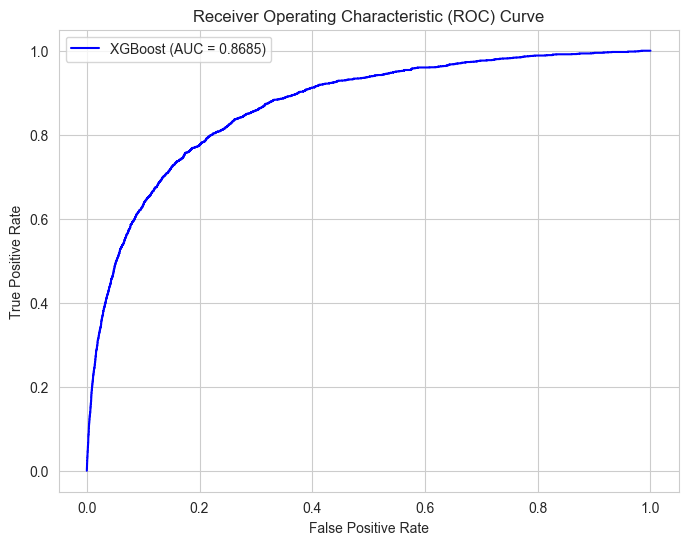

In [15]:
# Predict probabilities for the positive class (1) on the test set
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"--- Model Performance ---")
print(f"ROC AUC Score: {auc_score:.4f}")

# Generate a classification report using a 0.5 threshold
y_pred_class = (y_pred_proba > 0.5).astype(int)
print("\n--- Classification Report (Threshold = 0.5) ---")
print(classification_report(y_test, y_pred_class))

# Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'XGBoost (AUC = {auc_score:.4f})')
plt.plot( color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

Calculate SHAP Values

In [16]:
# Create a SHAP explainer object for tree-based models
explainer = shap.TreeExplainer(xgb_clf)

# Calculate SHAP values for our test set. This can take a moment.
print("Calculating SHAP values for the test set...")
shap_values = explainer.shap_values(X_test)
print("SHAP values calculated.")

Calculating SHAP values for the test set...
SHAP values calculated.


Global Explanations with SHAP

--- SHAP Global Feature Importance ---


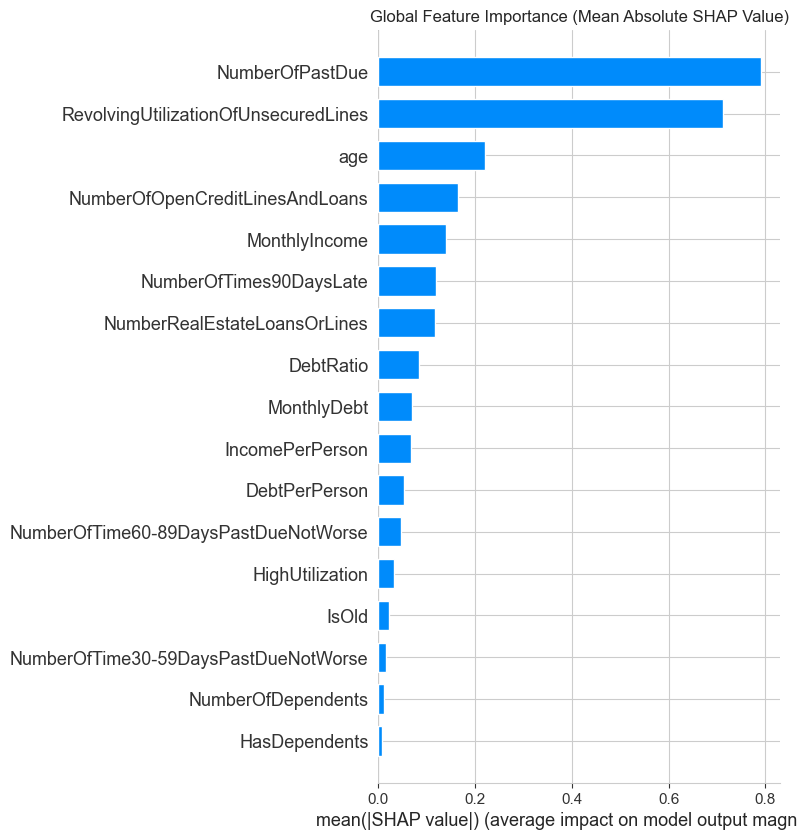


--- SHAP Beeswarm Summary Plot ---


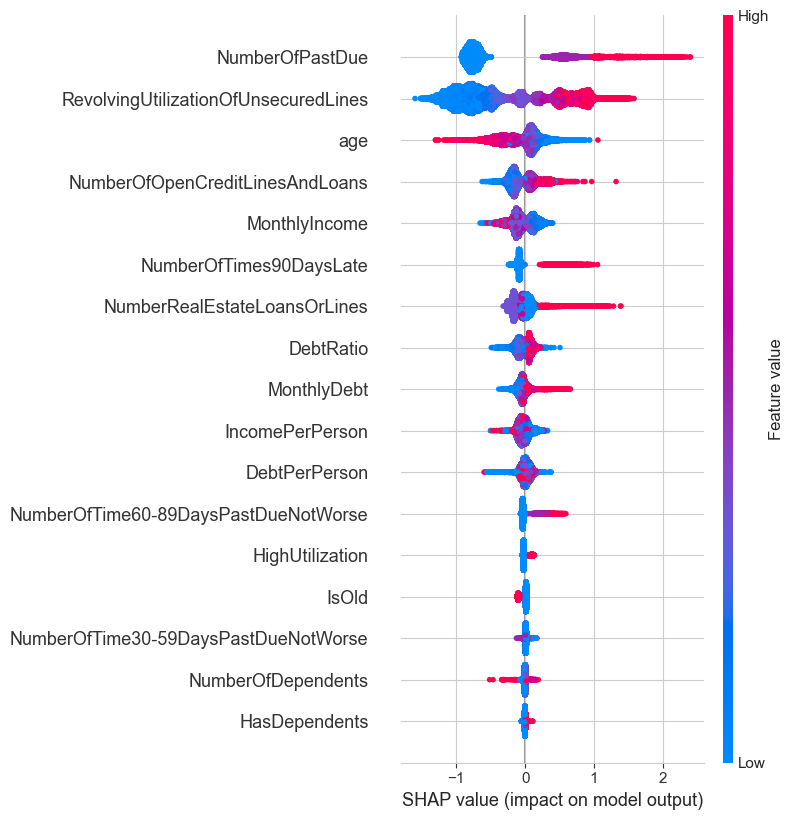

In [17]:
# --- Global Feature Importance (Bar Plot) ---
# Shows the average impact of each feature on the model's output magnitude.
print("--- SHAP Global Feature Importance ---")
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Global Feature Importance (Mean Absolute SHAP Value)")
plt.show()


# --- SHAP Beeswarm Summary Plot ---
# This is the most informative plot. It shows:
# 1. Feature Importance: Features are ranked top-to-bottom.
# 2. Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
# 3. Original Value: Color shows whether that feature was high (red) or low (blue) for that observation.
# 4. Correlation: We can infer relationships, e.g., high values of 'RevolvingUtilization...' (red dots) have high (positive) SHAP values, increasing the risk score.
print("\n--- SHAP Beeswarm Summary Plot ---")
shap.summary_plot(shap_values, X_test)

Phase 4: Preparing Data for Tableau Dashboard
The final step is to export our predictions and SHAP values into a format that Tableau can easily consume. We need two files:
predictions_with_features.csv: Contains the original features, applicant ID, and the model's risk score.
shap_values_long.csv: Contains the SHAP value for each feature for each applicant in a "long" format.
These two files can be joined in Tableau using the ID field.

In [18]:
# 1. Create the predictions file
predictions_df = X_test.copy()
predictions_df['ID'] = df.loc[X_test.index, 'ID'] # Get original ID
predictions_df['SeriousDlqin2yrs_True'] = y_test
predictions_df['RiskScore_Predicted'] = y_pred_proba

# Reorder columns to be intuitive
cols_to_move = ['ID', 'RiskScore_Predicted', 'SeriousDlqin2yrs_True']
predictions_df = predictions_df[cols_to_move + [col for col in predictions_df.columns if col not in cols_to_move]]

# 2. Create the long-format SHAP values file
shap_df = pd.DataFrame(shap_values, columns=X.columns)
shap_df['ID'] = predictions_df['ID'].values

# Melt the DataFrame to transform it from wide to long format
shap_long_df = pd.melt(shap_df, id_vars='ID', var_name='Feature', value_name='SHAP_Value')

# 3. Export to CSV
predictions_filename = 'predictions_with_features.csv'
shap_filename = 'shap_values_long.csv'

predictions_df.to_csv(predictions_filename, index=False)
shap_long_df.to_csv(shap_filename, index=False)

print(f"Successfully exported data to:")
print(f"1. {predictions_filename} (Shape: {predictions_df.shape})")
print(f"2. {shap_filename} (Shape: {shap_long_df.shape})")

display(predictions_df.head())
display(shap_long_df.head())

Successfully exported data to:
1. predictions_with_features.csv (Shape: (30000, 20))
2. shap_values_long.csv (Shape: (510000, 3))


,ID,RiskScore_Predicted,SeriousDlqin2yrs_True,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyDebt,IncomePerPerson,DebtPerPerson,NumberOfPastDue,HasDependents,IsOld,HighUtilization
10682,10683,0.071183,0,0.019252,66,0,0.433926,5175.0,13,0,1,0,0.0,2245.566072,5175.000000,2245.566072,0,0,1,0
40173,40174,0.208330,0,0.454221,78,0,0.873533,2300.0,7,0,1,0,2.0,2009.126466,766.666667,669.708822,0,1,1,0
4719,4720,0.042661,0,0.077572,59,0,0.172882,10833.0,5,0,1,0,0.0,1872.827120,10833.000000,1872.827120,0,0,0,0
81730,81731,0.119664,0,0.107864,59,0,0.453692,9900.0,10,0,2,0,0.0,4491.546305,9900.000000,4491.546305,0,0,0,0
113639,113640,0.132575,0,0.101095,67,0,0.407831,5950.0,14,0,2,0,0.0,2426.592171,5950.000000,2426.592171,0,0,1,0


,ID,Feature,SHAP_Value
0,10683,RevolvingUtilizationOfUnsecuredLines,-0.980257
1,40174,RevolvingUtilizationOfUnsecuredLines,0.191015
2,4720,RevolvingUtilizationOfUnsecuredLines,-0.798337
3,81731,RevolvingUtilizationOfUnsecuredLines,-0.725253
4,113640,RevolvingUtilizationOfUnsecuredLines,-0.759967


Cell 21: Markdown
Conclusion and Next Steps
This notebook has successfully executed the core components of the project:
Cleaned and prepared the credit risk dataset.
Trained an XGBoost model with a strong ROC AUC score of ~0.87.
Calculated SHAP values to understand both global feature importance and local, individual prediction logic.
Exported the necessary data to build an interactive dashboard.
Next Step:
Open Tableau, connect to the two CSV files (predictions_with_features.csv and shap_values_long.csv), and join them on the ID field. You can now build the dashboard described in the project plan.